In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
import math 
import copy
import pickle
import gc
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
import warnings 
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

## Step 1. Data Loading

In [ ]:
TARGET = 'Response'
FOLDS = 5
SEED = 94
ES_ROUNDS = 200
LOG_STEPS = 500

In [ ]:
print('Loading Data...')
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

submission_data = pd.read_csv('input/sample_submission.csv')

print('Data Load Successfully.')

In [ ]:
train.shape, test.shape

In [ ]:
#Combine daataset for processing
train['is_train'] = 1
test['is_train'] = 0

df = pd.concat([train, test])
df.head()

## Step 2. Data processing

In [ ]:
# Check missing values
df.isnull().sum()

In [ ]:
def transform_categorical_features(df):
    print('Transforming categorical features..')

    gender_map = {'Male': 0, 'Female': 1}
    vehicle_age = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years	': 2}
    vehicle_damage = {'No':0, 'Yes':1}

    df['Gender'] = df['Gender'].map(gender_map)
    df['Vehicle_Age'] = df['Vehicle_Age'].map(vehicle_age)
    df['Vehicle_Damage'] = df['Vehicle_Damage'].map(vehicle_damage)

    return df

In [ ]:
def adjust_data_types(df):
    print('Adjusting data types')
    df['Region_Code'] = df['Region_Code'].astype(int)
    df['Annual_Premium'] = df['Annual_Premium'].astype(int)
    df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype(int)
    
    return df

In [104]:
def create_additional_features(df):
    print('Creating additional features..')
    
    df['Prev_Insured_Annual_Premium'] = pd.factorize(df['Previously_Insured'].astype(str) + df['Annual_Premium'].astype(str))[0]
    df['Prev_Insured_Vehicle_Age'] = pd.factorize(df['Previously_Insured'].astype(str) + df['Vehicle_Age'].astype(str))[0]
    df['Prev_Insured_Vehicle_Damage'] = pd.factorize(df['Previously_Insured'].astype(str) + df['Vehicle_Damage'].astype(str))[0]
    df['Prev_Insured_Vintage'] = pd.factorize(df['Previously_Insured'].astype(str) + df['Vintage'].astype(str))[0]

    return df

In [105]:
def optimize_memory_usage(df):
    print('Optimizing memory usage')
    start_mem_usage = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        if col_type.name in ['category', 'object']:
            raise ValueError(f"Column '{col}' is of type '{col_type.name}'")

        c_min = df[col].min()
        c_max = df[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)

    end_mem_usage = df.memory_usage().sum() / 1024**2
    print(f'------ Memory usage before: {start_mem_usage:.2f} MB')
    print(f'------ Memory usage after: {end_mem_usage:.2f} MB')
    print(f'------ Reduced memory usage by {(100 * (start_mem_usage - end_mem_usage) / start_mem_usage):.1f}%')

    return df

In [106]:
df = transform_categorical_features(df)
df = adjust_data_types(df)
df = optimize_memory_usage(df)
df = create_additional_features(df)

df.head()

Transforming categorical features..


NotImplementedError: float16 indexes are not supported

In [ ]:
unique_values = df['Prev_Insured_Vehicle_Age'].unique()
print(unique_values)

## Step 3. Data visualization

In [ ]:
# Compute the correlation matrix
corr = df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [98]:
sample_df = df.sample(frac=0.1, random_state=1)  # Sample 10% of the data

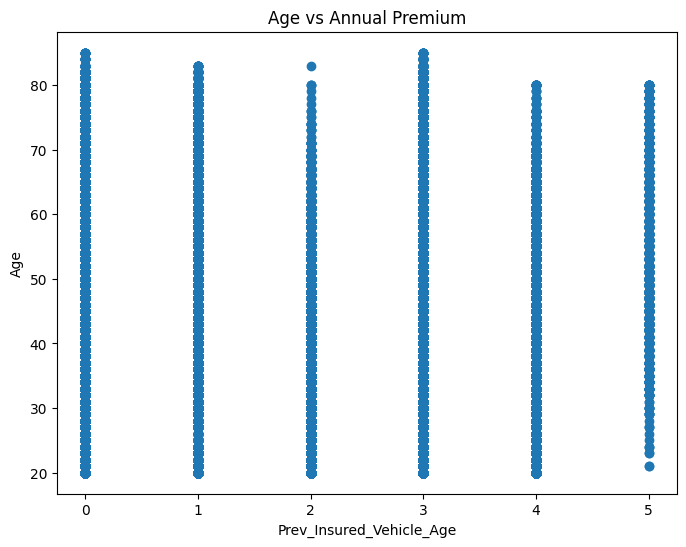

In [99]:
# Scatter plot of Age vs Annual Premium
plt.figure(figsize=(8, 6))
plt.scatter(df['Prev_Insured_Vehicle_Age'], df['Age'])
plt.xlabel('Prev_Insured_Vehicle_Age')
plt.ylabel('Age')
plt.title('Age vs Annual Premium')
plt.show()

## Step 4. Prepare features and target

In [100]:
# Split the data back into train and test sets
train = df[df['is_train'] == 1].drop(columns=['is_train'])
test = df[df['is_train'] == 0].drop(columns=['is_train'])

X_train = train.drop(columns=['Response'])
y_train = train['Response']

X_test = test
y_test = submission_data